# Bibliotecas

In [3]:
import re
import time
import nltk
import string
import requests
import seaborn           as sns
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt


from dateutil                        import parser
from collections                     import Counter
from datetime                        import datetime
from nltk.corpus                     import stopwords
from collections                     import defaultdict
from nltk.tokenize                   import word_tokenize
from bs4                             import BeautifulSoup
from wordcloud                       import WordCloud, STOPWORDS
from nltk.stem                       import SnowballStemmer, WordNetLemmatizer
from dateutil.relativedelta          import relativedelta
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment                  import SentimentIntensityAnalyzer
from sklearn.model_selection         import train_test_split
from sklearn.linear_model            import LogisticRegression
from sklearn.metrics                 import accuracy_score

# Coleta de textos

In [ ]:
# empty dataframe
df_operadora = pd.DataFrame()

cols = ['operadora','title_text', 'reclamacao_text', 'status_text', 'data_text']
df_pattern = pd.DataFrame( columns=cols )

paginas = [str(i) for i in range(1, 500)]
operadoras = ['amil', 'bradesco-saude', 'notredame-intermedica', 'hapvida-saude', 'sulamerica-saude', 'prevent-senior', 'unimed-bh', 'unimed-rio-rj']

for operadora in operadoras:
    for pagina_atual in paginas:
        #print(pagina_atual)
        # API Requests
        url = 'https://www.reclameaqui.com.br/empresa/'+ operadora +'/lista-reclamacoes/?pagina=' + pagina_atual + '&status=EVALUATED'

        page = requests.get( url, headers=headers )

        # Beautiful Soup object
        soup =  BeautifulSoup( page.text, 'html.parser' )

        #================titulo===========#
        operadora_title = soup.find('h4', class_='sc-1pe7b5t-1 jAlTVn')
        title_text = operadora_title.text

        #================reclamacao===========#
        operadora_reclamacao = soup.find('p', class_='sc-1pe7b5t-2 jmCUqY')
        reclamacao_text = operadora_reclamacao.text

        #================status===========#
        operadora_status = soup.find('span', class_='sc-1pe7b5t-4 bfIEOo')
        status_text = operadora_status.text

        #================data===========#
        operadora_data = soup.find('span', class_='sc-1pe7b5t-5 bmtSzo')
        data_text = operadora_data.text

        dicionario = {'operadora': operadora, 'title_text': title_text, 'reclamacao_text': reclamacao_text, 'status_text': status_text, 'data_text': data_text}
        df_operadora = pd.concat([df_operadora, pd.DataFrame(dicionario, index=[0])], ignore_index=True)

        # wait for 1 second to avoid connection issues
        time.sleep(1)
        
# add scrapy datetime
df_operadora['scrapy_datetime'] = datetime.now().strftime( '%Y-%m-%d %H:%M:%S' )

data_raw = df_operadora

In [ ]:
data_raw.to_csv('operadoras.csv', index=False)

# Análise Exploratória dos textos

In [5]:
df_operadora = pd.read_csv('operadoras.csv')

In [6]:
df_operadora.head()

,operadora,title_text,reclamacao_text,status_text,data_text,scrapy_datetime
0,amil,"COBRANÇA INDEVIDA, OBRIGAÇÃO DE AVISO PRÉVIO I...",Ao cancelar meu Plano de Saúde AMIL (Contrato ...,Resolvido,Há 2 dias,2023-05-06 16:55:19
1,amil,NÃO TEM VAGAS PARA OBSTRETA,Boa tarde; minha esposa descobril que estav...,Resolvido,Há 3 dias,2023-05-06 16:55:19
2,amil,Amil quer mesmo se livrar dos planos individuais,A amil realmente quer se livrar de tds q tem p...,Resolvido,Há 4 dias,2023-05-06 16:55:19
3,amil,"A Amil nunca paga reembolso das cirurgias, só ...",Já perdi as contas de quantas vezes abri recla...,Resolvido,Há 4 dias,2023-05-06 16:55:19
4,amil,Amil não atende seus clientes,Recebo minha fatura mensal por email. Ocorre q...,Resolvido,Há 4 dias,2023-05-06 16:55:19


In [7]:
# Percorre cada linha do DataFrame
for i, row in df_operadora.iterrows():
    # Obtém o valor do campo scrapy_datetime da linha atual
    scrapy_datetime = row['scrapy_datetime']
    
    # Converte a string em um objeto datetime e formata a data
    dt = datetime.strptime(scrapy_datetime, '%Y-%m-%d %H:%M:%S')
    date_string = dt.strftime('%Y-%m-%d')
    
    # Substitui o valor da coluna scrapy_datetime pelo valor formatado
    df_operadora.at[i, 'scrapy_datetime'] = date_string

In [8]:
# Converte as informações de tempo para uma data exata
for i in range(len(df_operadora)):
    if 'dia' in df_operadora['data_text'][i]:
        days_ago = int(df_operadora['data_text'][i].split()[1])
        df_operadora.at[i, 'data_resposta'] = datetime.strptime(df_operadora['scrapy_datetime'][i], '%Y-%m-%d') - relativedelta(days=days_ago)
    elif 'semana' in df_operadora['data_text'][i]:
        weeks_ago = int(df_operadora['data_text'][i].split()[1])
        df_operadora.at[i, 'data_resposta'] = datetime.strptime(df_operadora['scrapy_datetime'][i], '%Y-%m-%d') - relativedelta(weeks=weeks_ago)
    elif 'mês' in df_operadora['data_text'][i]:
        months_ago = int(df_operadora['data_text'][i].split()[1])
        df_operadora.at[i, 'data_resposta'] = datetime.strptime(df_operadora['scrapy_datetime'][i], '%Y-%m-%d') - relativedelta(months=months_ago)
    
# Converte a coluna 'data_resposta' para o formato datetime
df_operadora['data_resposta'] = pd.to_datetime(df_operadora['data_resposta'], format='%Y-%m-%d')

In [9]:
print('Número de reclamações: ', len(df_operadora))
print('Número de operadoras: ', len(df_operadora['operadora'].unique()))

Número de reclamações:  3992
Número de operadoras:  8


In [10]:
#Verificar estatísticas básicas dos dados numéricos:
df_operadora.describe()

/tmp/ipykernel_4234/4112522060.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_operadora.describe()


,operadora,title_text,reclamacao_text,status_text,data_text,scrapy_datetime,data_resposta
count,3992,3992,3992,3992,3992,3992,2646
unique,8,3666,3985,1,32,1,26
top,amil,Reembolso,"PREZADOS, BOA TARDE!POSSUO UMA AUTORIZAÇÃO PAR...",Resolvido,Há 1 mês,2023-05-06,2023-04-06 00:00:00
freq,499,36,2,3992,1455,3992,1455
first,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-06 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-05 00:00:00


/home/rafael/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


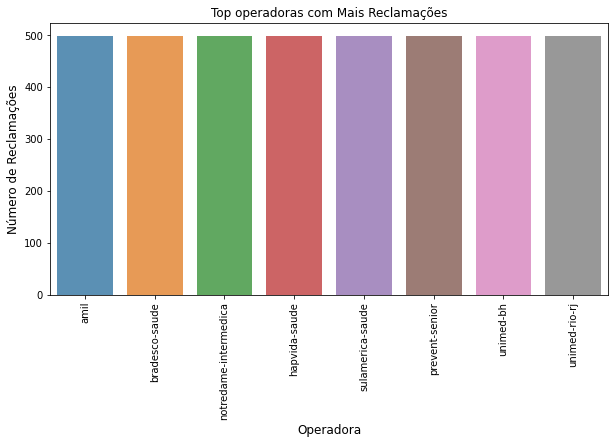

In [11]:
top_operadora = df_operadora['operadora'].value_counts().head(8)
plt.figure(figsize=(10,5))
sns.barplot(top_operadora.index, top_operadora.values, alpha=0.8)
plt.title('Top operadoras com Mais Reclamações')
plt.ylabel('Número de Reclamações', fontsize=12)
plt.xlabel('Operadora', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [12]:
df_operadora.head()

,operadora,title_text,reclamacao_text,status_text,data_text,scrapy_datetime,data_resposta
0,amil,"COBRANÇA INDEVIDA, OBRIGAÇÃO DE AVISO PRÉVIO I...",Ao cancelar meu Plano de Saúde AMIL (Contrato ...,Resolvido,Há 2 dias,2023-05-06,2023-05-04
1,amil,NÃO TEM VAGAS PARA OBSTRETA,Boa tarde; minha esposa descobril que estav...,Resolvido,Há 3 dias,2023-05-06,2023-05-03
2,amil,Amil quer mesmo se livrar dos planos individuais,A amil realmente quer se livrar de tds q tem p...,Resolvido,Há 4 dias,2023-05-06,2023-05-02
3,amil,"A Amil nunca paga reembolso das cirurgias, só ...",Já perdi as contas de quantas vezes abri recla...,Resolvido,Há 4 dias,2023-05-06,2023-05-02
4,amil,Amil não atende seus clientes,Recebo minha fatura mensal por email. Ocorre q...,Resolvido,Há 4 dias,2023-05-06,2023-05-02


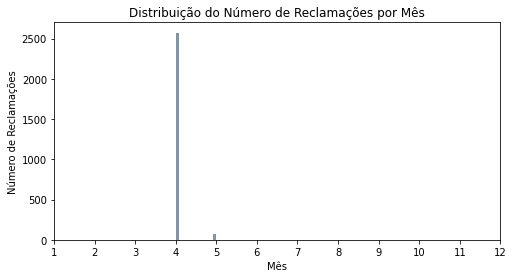

In [13]:
# Cria uma nova coluna com o mês de cada reclamação
df_operadora['mes'] = df_operadora['data_resposta'].dt.month

# Plota um histograma do número de reclamações por mês
plt.figure(figsize=(8,4))
plt.hist(df_operadora['mes'], bins=12, color='#607c8e', alpha=0.8)
plt.title('Distribuição do Número de Reclamações por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Reclamações')
plt.xticks(range(1, 13))
plt.show()

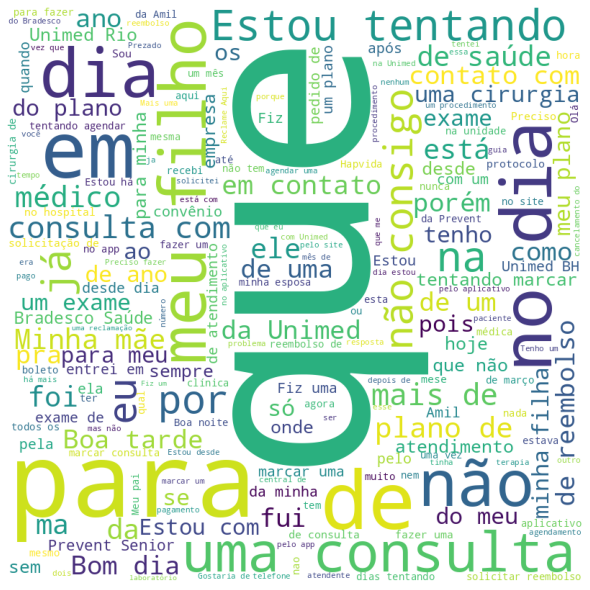

In [14]:
# Plota uma word cloud com as palavras mais frequentes nas reclamações
text = ' '.join(df_operadora['reclamacao_text'].tolist())
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text) 
                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

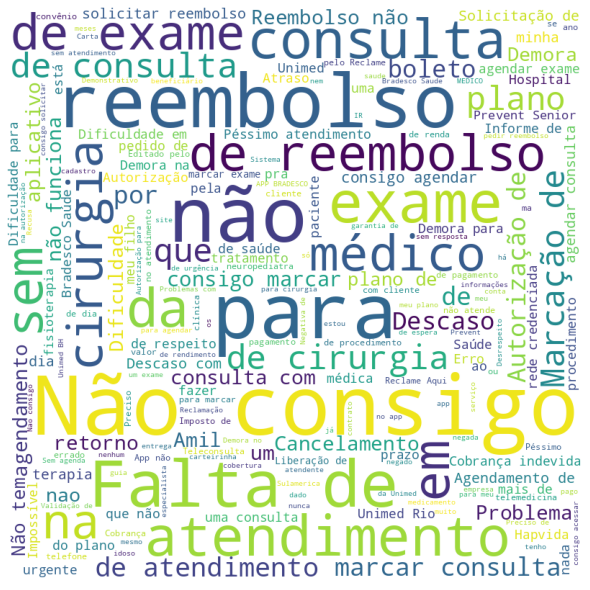

In [15]:
# Plota uma word cloud com as palavras mais frequentes nas titulo
text = ' '.join(df_operadora['title_text'].tolist())
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text) 
                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<AxesSubplot:>

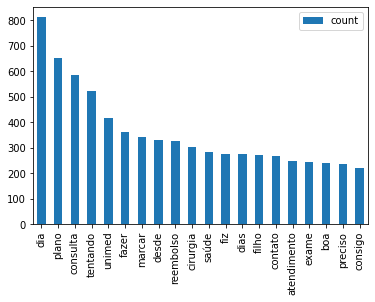

In [16]:
#Verificar as palavras mais comuns nas reclamações:

stop_words = stopwords.words('portuguese') + list(string.punctuation)

words = df_operadora['reclamacao_text'].str.lower().str.split()
words = words.explode()
words = words[~words.isin(stop_words)]
words_count = Counter(words)

words_count_df = pd.DataFrame.from_dict(words_count, orient='index', columns=['count'])
words_count_df = words_count_df.sort_values(by='count', ascending=False)

words_count_df.head(20).plot(kind='bar')

<AxesSubplot:>

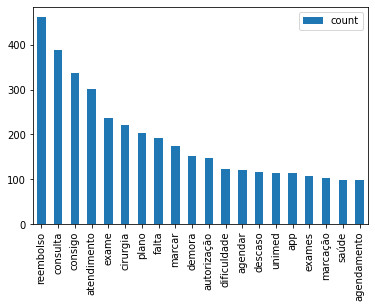

In [17]:
#Verificar as palavras mais comuns nas titulos:

stop_words = stopwords.words('portuguese') + list(string.punctuation)

words = df_operadora['title_text'].str.lower().str.split()
words = words.explode()
words = words[~words.isin(stop_words)]
words_count = Counter(words)

words_count_df = pd.DataFrame.from_dict(words_count, orient='index', columns=['count'])
words_count_df = words_count_df.sort_values(by='count', ascending=False)

words_count_df.head(20).plot(kind='bar')

In [18]:
# Cria uma lista com todas as palavras presentes na coluna 'texto_resposta'
all_words = [word for text in df_operadora['reclamacao_text'] for word in word_tokenize(text)]

# Calcula a frequência de cada palavra e ordena do mais frequente ao menos frequente
freq_dist = nltk.FreqDist(all_words)
freq_dist_sorted = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)

# Imprime as 20 palavras mais frequentes
for word, frequency in freq_dist_sorted[:20]:
    print(f'{word}: {frequency}')

,: 4116
de: 3731
e: 2322
a: 2142
o: 2106
para: 1601
com: 1587
.: 1553
que: 1433
uma: 1232
um: 1172
no: 1061
não: 1039
da: 999
*: 955
do: 932
em: 907
dia: 875
meu: 657
plano: 656


In [19]:
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# Criar uma lista de tokens sem as stopwords
tokens = df_operadora['reclamacao_text'].str.lower().str.split()
tokens_sem_stopwords = [token for lista in tokens for token in lista if token not in stopwords_pt]

# Contar a frequência de cada palavra
counter = Counter(tokens_sem_stopwords)

# Classificar as palavras por ordem decrescente de frequência
palavras_frequencia = counter.most_common()

# Imprime as 20 palavras mais frequentes
for counter, palavras_frequencia in palavras_frequencia[:20]:
    print(f'{counter}: {palavras_frequencia}')

dia: 813
plano: 651
consulta: 584
tentando: 521
unimed: 418
fazer: 363
marcar: 342
desde: 331
reembolso: 325
cirurgia: 301
saúde: 281
fiz: 275
dias: 275
filho: 272
contato: 266
atendimento: 248
exame: 245
boa: 240
preciso: 236
consigo: 219


[nltk_data] Downloading package stopwords to /home/rafael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Cria uma lista com todas as palavras do dataframe
todas_palavras = ' '.join(df_operadora['reclamacao_text']).lower().split()

# Remove as stopwords da lista
palavras_sem_stopwords = [palavra for palavra in todas_palavras if palavra not in stopwords.words('portuguese')]

# Conta a frequência de cada palavra na lista
palavras_frequencia = sorted(Counter(palavras_sem_stopwords).items(), key=lambda x: x[1], reverse=False)

# Imprime as 20 palavras menos frequentes
for counter, palavras_frequencia in palavras_frequencia[:20][::-1]:
    print(f'{counter}: {palavras_frequencia}')

invasor: 1
junho!: 1
bloqu: 1
envolve: 1
sugeriu: 1
ombros: 1
acostumada: 1
proecho: 1
tomografia,: 1
marcas: 1
individuais.: 1
tds: 1
traçando: 1
descobril: 1
tarde;: 1
negar: 1
indevido,: 1
cobrou: 1
pj): 1
(contrato: 1


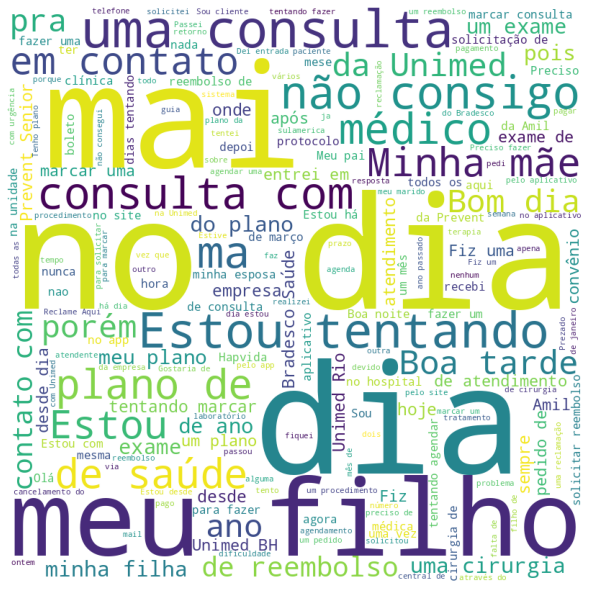

In [21]:
# Lista de stopwords em Português
stopwords_pt = set(stopwords.words('portuguese'))

# Concatena as reclamações em uma única string
text = ' '.join(df_operadora['reclamacao_text'].tolist())

# Cria a WordCloud sem as stopwords
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords_pt,
                      min_font_size=10).generate(text) 

# Plota a WordCloud
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show() 


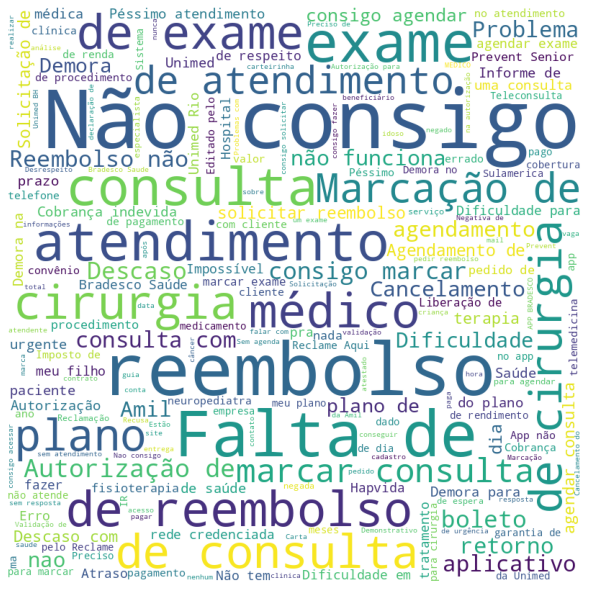

In [22]:
# Lista de stopwords em Português
stopwords_pt = set(stopwords.words('portuguese'))

# Concatena as reclamações em uma única string
text = ' '.join(df_operadora['title_text'].tolist())

# Cria a WordCloud sem as stopwords
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords_pt,
                      min_font_size=10).generate(text) 

# Plota a WordCloud
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show() 

# Pré-processamento de textos

In [23]:
# Define o idioma para utilização das stopwords e stemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('portuguese'))
stemmer = SnowballStemmer('portuguese')
lemmatizer = WordNetLemmatizer()

# Função para pré-processamento de uma única frase
def preprocess_text(text):
    # Converte para lower case
    text = text.lower()
    
    # Remove URLs e HTML tags
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    # Remove emojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
   
    # Remove pontuações e números
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokeniza o texto
    tokens = word_tokenize(text)
    
    # Remove as stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    
    # Retorna o texto pré-processado como string
    return ' '.join(filtered_tokens)

# Aplica a função de pré-processamento para o DataFrame inteiro
df_operadora['reclamacao_text_preprocessed'] = df_operadora['reclamacao_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/rafael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rafael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rafael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
df_operadora

,operadora,title_text,reclamacao_text,status_text,data_text,scrapy_datetime,data_resposta,mes,reclamacao_text_preprocessed
0,amil,"COBRANÇA INDEVIDA, OBRIGAÇÃO DE AVISO PRÉVIO I...",Ao cancelar meu Plano de Saúde AMIL (Contrato ...,Resolvido,Há 2 dias,2023-05-06,2023-05-04,5.0,cancelar plano sade amil contrato pj operadora...
1,amil,NÃO TEM VAGAS PARA OBSTRETA,Boa tarde; minha esposa descobril que estav...,Resolvido,Há 3 dias,2023-05-06,2023-05-03,5.0,boa tarde esposa descobril grvida meses deste ...
2,amil,Amil quer mesmo se livrar dos planos individuais,A amil realmente quer se livrar de tds q tem p...,Resolvido,Há 4 dias,2023-05-06,2023-05-02,5.0,amil realmente quer livrar tds q planos indivi...
3,amil,"A Amil nunca paga reembolso das cirurgias, só ...",Já perdi as contas de quantas vezes abri recla...,Resolvido,Há 4 dias,2023-05-06,2023-05-02,5.0,j perdi contas quantas vezes abri reclamao ans...
4,amil,Amil não atende seus clientes,Recebo minha fatura mensal por email. Ocorre q...,Resolvido,Há 4 dias,2023-05-06,2023-05-02,5.0,recebo fatura mensal email ocorre mes mesma ch...
...,...,...,...,...,...,...,...,...,...
3987,unimed-rio-rj,Dificuldade em marcar consulta,Estou precisando marcar uma consulta com psiqu...,Resolvido,Há 5 meses,2023-05-06,NaT,NaN,precisando marcar consulta psiquiatra pra pega...
3988,unimed-rio-rj,autorização de Cirurgia,tenho câncer de mama e preciso urgentemente de...,Resolvido,Há 5 meses,2023-05-06,NaT,NaN,cncer mama preciso urgentemente cirurgia maste...
3989,unimed-rio-rj,Autorização de Procedimento de EMERGENCIA NA UTI.,Meu Avó teve um infarto dia 22 e foi internado...,Resolvido,Há 5 meses,2023-05-06,NaT,NaN,av infarto dia internado uti fazer cirurgia ca...
3990,unimed-rio-rj,DEMORA NA LIBERAÇÃO DE CIRURGIA,SOU CLIENTE DA UNIMED RIO DESDE 17/06/2015 CAR...,Resolvido,Há 5 meses,2023-05-06,NaT,NaN,cliente unimed rio desde carteirinha n dei ent...


# Engenharia de Característica de textos

In [25]:
# Define as etapas de pré-processamento a serem realizadas nas reclamações
stop_words = set(stopwords.words('portuguese'))
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuations
    text = re.sub(r'\b\d+\b', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplica o pré-processamento nas reclamações
df_operadora['reclamacao_text_preprocessed'] = df_operadora['reclamacao_text'].apply(preprocess_text)

# Cria o bag of words
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df_operadora['reclamacao_text_preprocessed'])

# Verifica a contagem da palavra "consulta"
word_count = vectorizer.get_feature_names().index('consulta')
total_count = bag_of_words[:, word_count].sum()
print(f'A palavra "internet" aparece {total_count} vezes nas reclamações.')

A palavra "internet" aparece 616 vezes nas reclamações.


/home/rafael/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
# Obtém a contagem de cada palavra
word_count = Counter(vectorizer.get_feature_names())
# Obtém as 20 palavras mais frequentes
top_words = word_count.most_common(20)
print('20 palavras mais frequentes:')
for word, count in top_words:
    print(f'{word}: {count}')

20 palavras mais frequentes:
0084diogo: 1
0097prazo: 1
00hs: 1
00liguei: 1
02demorou: 1
03abr: 1
0641c: 1
07h40: 1
07hs: 1
0quando: 1
10h15: 1
10h30: 1
11h30: 1
11h31: 1
12380no: 1
12h: 1
12h38: 1
12xeu: 1
133kg: 1
13hora: 1


# Modelagem

In [27]:
# Baixa os recursos necessários
nltk.download('vader_lexicon')

# Cria uma instância do SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Aplica o SentimentIntensityAnalyzer em cada reclamação e adiciona as pontuações como colunas no df_operadora
df_operadora['sentiment'] = df_operadora['reclamacao_text_preprocessed'].apply(lambda text: sid.polarity_scores(text))
df_operadora['sentiment_pos'] = df_operadora['sentiment'].apply(lambda scores: scores['pos'])
df_operadora['sentiment_neg'] = df_operadora['sentiment'].apply(lambda scores: scores['neg'])
df_operadora['sentiment_neu'] = df_operadora['sentiment'].apply(lambda scores: scores['neu'])
df_operadora['sentiment_compound'] = df_operadora['sentiment'].apply(lambda scores: scores['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rafael/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [28]:
# Define um limiar de corte para transformar as pontuações em uma variável binária
threshold = 0.0
df_operadora['sentiment_binary'] = df_operadora['sentiment_compound'].apply(lambda score: 1 if score > threshold else 0)

# Divide os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df_operadora['sentiment_binary'], test_size=0.2, random_state=42)

# Treina o modelo de Regressão Logística
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Faz as previsões no conjunto de teste
y_pred = lr.predict(X_test)

# Avalia a acurácia do modelo
acc = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {acc}')

Acurácia do modelo: 0.9799749687108886


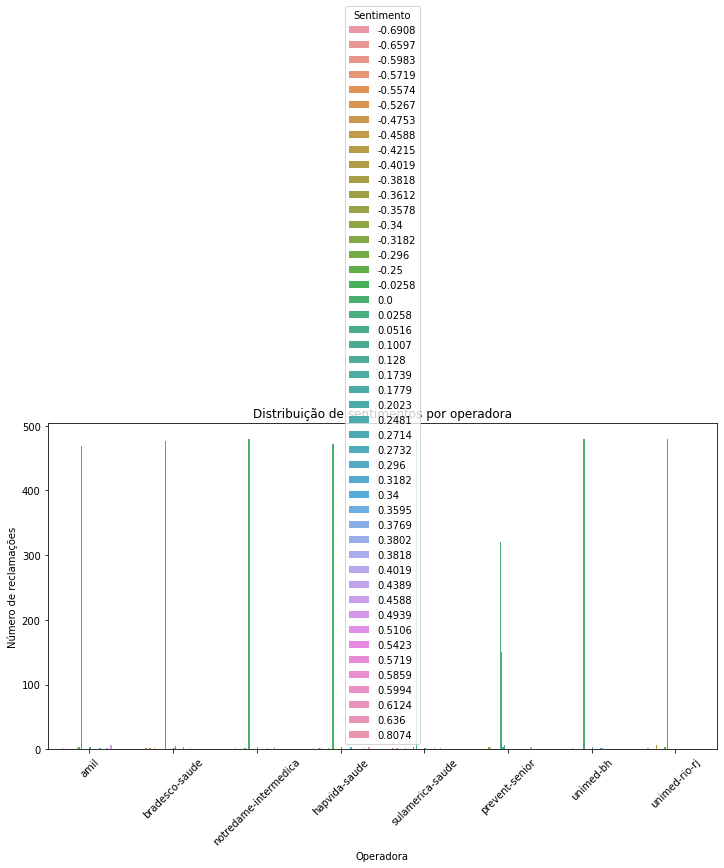

In [29]:
# Distribuição de sentimentos por operadora
plt.figure(figsize=(12, 6))
sns.countplot(data=df_operadora, x='operadora', hue='sentiment_compound')
plt.title('Distribuição de sentimentos por operadora')
plt.xlabel('Operadora')
plt.ylabel('Número de reclamações')
plt.xticks(rotation=45)
plt.legend(title='Sentimento')
plt.show()